In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from math import sqrt
#import xgboost as xgb

from xgboost import XGBRegressor
from xgboost import plot_importance
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))


# Any results you write to the current directory are saved as output.

['lerning_model_train.csv', 'lerning_model_test.csv']


In [2]:
#Load data for analysis
df_train = pd.read_csv("../input/lerning_model_train.csv")
df_test = pd.read_csv("../input/lerning_model_test.csv")

In [3]:
df_train.head()

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled
0,07659f3758d8aee27f5a7e2887adeacb67021cb95ada1b...,05/04/18,05/04/18,06/04/18,3,1,2,0,46,3,3,3,1,2.0,7.0,3,3,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,C,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,7.706428
1,03930f033646d073462b35d411616323597715ac4fc398...,23/01/15,11/04/15,16/04/15,1,1,2,0,46,3,3,4,5,2.0,7.0,5,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,A,39fa9ec190eee7b6f4dff1100d6343e10918d044c75eac...,6.662563
2,d145a32920e6587ad95bfe299d80c0affa268220535aaf...,28/01/15,01/02/15,05/02/15,1,1,2,0,47,1,5,4,4,2.0,7.0,1,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,E,A,535fa30d7e25dd8a49f1536779734ec8286108d115da50...,7.871602
3,cfd77f44811ed62f25a220b53324cdbafc662a4c9e5f04...,02/05/15,11/06/15,16/06/15,1,1,2,2,46,2,2,3,5,2.0,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,5.344943
4,937cff9e4dcfc2459620153dfc8b9962ac22bea67dfb29...,02/09/15,14/12/15,19/12/15,1,1,2,0,46,2,2,4,5,2.0,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,7.059346


In [4]:
df_train.shape


(341424, 24)

In [5]:
#check how much data we have
print("shape of training set is ",df_train.shape)
print("shape of test set is ",df_test.shape)

shape of training set is  (341424, 24)
shape of test set is  (146765, 23)


In [6]:
#understanding numeric variables
df_train.describe()

#observations
#season_holidayed_code and state_code_residence might have null values in them
#total_pax (ppl traveling) has min value 0 this might be data descripency
#max for numberofadults is 32 where as for total_pax is 24 this might be data descripancy
#persontravellingid has value in 1000's for few records this is possible 
#rooms booked per night has negative min value this might be data descripency

#perform null checks train
df_train.isna().sum()
#perform null checks test
df_test.isna().sum()
#The portion is small (and same 2 columns) as compared to total data hence if not covered in preprocessing can be dropped

reservation_id                 0
booking_date                   0
checkin_date                   0
checkout_date                  0
channel_code                   0
main_product_code              0
numberofadults                 0
numberofchildren               0
persontravellingid             0
resort_region_code             0
resort_type_code               0
room_type_booked_code          0
roomnights                     0
season_holidayed_code         35
state_code_residence        2260
state_code_resort              0
total_pax                      0
member_age_buckets             0
booking_type_code              0
memberid                       0
cluster_code                   0
reservationstatusid_code       0
resort_id                      0
dtype: int64

In [7]:
#check for common reservation_ids 
reservation_prop = len(set(df_train.reservation_id.unique()).intersection(df_test.reservation_id.unique())) / len(df_train.reservation_id.unique())
print('Proportion of reservation train ids that are in test: {}%'.format(round(reservation_prop * 100, 2)))
#check for common memberid 
memberid_prop = len(set(df_train.memberid.unique()).intersection(df_test.memberid.unique())) / len(df_train.memberid.unique())
print('Proportion of member train ids that are in test: {}%'.format(round(memberid_prop * 100, 2)))
#There are no common ids which means we are looking at completely different member data in test set

Proportion of reservation train ids that are in test: 0.0%
Proportion of member train ids that are in test: 0.0%


In [8]:
def preProcessed (df_train):
	#data preprocessing

	print("Correcting default data types for dates - ")
	df_train['booking_date'] = pd.to_datetime(df_train['booking_date'])
	df_train['checkin_date'] = pd.to_datetime(df_train['checkin_date'])
	df_train['checkout_date'] = pd.to_datetime(df_train['checkout_date'])
	print("dates modified.\n Calculating staylength based on dates - ")
	df_train['staylength'] = abs((df_train['checkout_date']-df_train['checkin_date']).dt.days)
	print("stay length calculated. Calculating date based variables - ")
	df_train['checkinday'] = df_train['checkin_date'].dt.day
	df_train['checkinmonth'] = df_train['checkin_date'].dt.month
	df_train['checkinquarter'] = df_train['checkin_date'].dt.quarter
	df_train['checkinyear'] = df_train['checkin_date'].dt.year
	df_train['checkindayofweek'] = df_train['checkin_date'].dt.dayofweek #starts as monday 0
	df_train['checkinweekofyear'] = df_train['checkin_date'].dt.weekofyear

	#traveller checking out on a weekday is likely to spend more on weekends hence its imp to consider checkout dates as well
	df_train['checkoutday'] = df_train['checkout_date'].dt.day
	df_train['checkoutmonth'] = df_train['checkout_date'].dt.month
	df_train['checkoutquarter'] = df_train['checkout_date'].dt.quarter
	df_train['checkoutyear'] = df_train['checkout_date'].dt.year
	df_train['checkoutdayofweek'] = df_train['checkout_date'].dt.dayofweek #starts as monday 0
	df_train['checkoutweekofyear'] = df_train['checkout_date'].dt.weekofyear

	#early bookings have high chance of planned stay hence might consider more activities/expenditure at resort
	df_train['bookingdays'] = abs((df_train['checkin_date']-df_train['booking_date']).dt.days)
	#people checking in on weekend are likely to spend more in terms of food and baverages
	df_train['isweekend'] = 0
	df_train.loc[df_train.checkindayofweek > 4, 'isweekend'] = 1
	#remove origional date columns
	df_train = df_train.drop(columns=['booking_date','checkin_date','checkout_date'])
	print("date operations completed!")
	#df_train[df_train['staylength']<1] that means checkout date is earlier than checkin date #46K have this issue 
	#df_train[df_train['bookingdays']<1] that means checkin date is earlier than booking date #84K have this issue

	print("Beginning PAX update - ")
	#pax isn't right in data as per its definition. Modifying it to true sum of numberofadults and numberofchildren
	#there are rows where adults and children are 0 but total_pax has values, saving pax to dummy to save those rows
	df_train['dummytotal_pax'] = df_train['total_pax']
	df_train['total_pax'] = df_train['numberofadults']+df_train['numberofchildren']
	#df_train.total_pax.loc[df_train.numberofadults == 0&df_train.numberofchildren==0, 'total_pax'] = df_train['dummytotal_pax']
	#df_train[df_train['numberofadults']==0&df_train['numberofchildren']==0]=
	#df_train['total_pax'].describe()

	#Children are likely to persue parents to spend more money hence its important to have that feature
	df_train['havechildren'] = 0
	df_train.loc[df_train.numberofchildren > 0, 'havechildren'] = 1
	#dropping number of adults and children
	df_train = df_train.drop(columns=['numberofadults','numberofchildren','dummytotal_pax'])
	print("PAX update done!")

	print("Beginning travellingid update - ")
	df_train['dummypersontravellingid'] = df_train['persontravellingid']

	#travellingid type is categorical variable however needs to be scalled so that values do not have aftereffect
	df_train.loc[df_train.dummypersontravellingid ==45, 'persontravellingid'] = 1
	df_train.loc[df_train.dummypersontravellingid ==46, 'persontravellingid'] = 2
	df_train.loc[df_train.dummypersontravellingid ==47, 'persontravellingid'] = 3
	df_train.loc[df_train.dummypersontravellingid ==4752, 'persontravellingid'] = 4
	df_train.loc[df_train.dummypersontravellingid ==4753, 'persontravellingid'] = 5
	df_train.loc[df_train.dummypersontravellingid ==4995, 'persontravellingid'] = 6
	df_train = df_train.drop(columns=['dummypersontravellingid'])
	print("Travellingid update Done!")

	print("Beginnning set missing values for season and residency - ")
	#set missing values for season May 2016, Oct 2018, Jul aug 2015 with most common value for them for test and train
	#After quick ananlysis this is found to be 2
	df_train['season_holidayed_code'].replace(np.nan, 2, inplace= True)
	#performing same for state_code_residence
	df_train=df_train.fillna(df_train.mode().iloc[0])

	#convert these 2 columns to int for reducing size
	df_train['state_code_residence'] = df_train['state_code_residence'].astype(int)
	df_train['season_holidayed_code'] = df_train['season_holidayed_code'].astype(int)
	print("Setting missing values done!")

	print("mamber age bucket modification starting - ")
	df_train['dummymember_age_buckets'] = df_train['member_age_buckets']
	df_train.loc[df_train.dummymember_age_buckets =='A', 'member_age_buckets'] = 1
	df_train.loc[df_train.dummymember_age_buckets =='B', 'member_age_buckets'] = 2
	df_train.loc[df_train.dummymember_age_buckets =='C', 'member_age_buckets'] = 3
	df_train.loc[df_train.dummymember_age_buckets =='D', 'member_age_buckets'] = 4
	df_train.loc[df_train.dummymember_age_buckets =='E', 'member_age_buckets'] = 5
	df_train.loc[df_train.dummymember_age_buckets =='F', 'member_age_buckets'] = 6
	df_train.loc[df_train.dummymember_age_buckets =='G', 'member_age_buckets'] = 7
	df_train.loc[df_train.dummymember_age_buckets =='H', 'member_age_buckets'] = 8
	df_train.loc[df_train.dummymember_age_buckets =='I', 'member_age_buckets'] = 9
	df_train.loc[df_train.dummymember_age_buckets =='J', 'member_age_buckets'] = 10
	df_train = df_train.drop(columns=['dummymember_age_buckets'])
	print("member age bucket modification completed!")

	#fixing roomnights issue - checking if there are <1 rooms entered, which is not valid scenario
	#df_train[df_train['roomnights']<1]
	#there are only 2 records with roomnights <1 however in test set there is a 0 value record hence we need to keep it 
	#to maintain size of test set output
	df_train = df_train[df_train['roomnights']>=0]

	print("cluster code modification starting - ")
	df_train['dummycluster_code'] = df_train['cluster_code']
	df_train.loc[df_train.dummycluster_code =='A', 'cluster_code'] = 1
	df_train.loc[df_train.dummycluster_code =='B', 'cluster_code'] = 2
	df_train.loc[df_train.dummycluster_code =='C', 'cluster_code'] = 3
	df_train.loc[df_train.dummycluster_code =='D', 'cluster_code'] = 4
	df_train.loc[df_train.dummycluster_code =='E', 'cluster_code'] = 5
	df_train.loc[df_train.dummycluster_code =='F', 'cluster_code'] = 6
	df_train = df_train.drop(columns=['dummycluster_code'])
	print("cluster code modification completed.")

	print("reservation statusid_code modification starting - ")
	df_train['dummyreservationstatusid_code'] = df_train['reservationstatusid_code']
	df_train.loc[df_train.dummyreservationstatusid_code =='A', 'reservationstatusid_code'] = 1
	df_train.loc[df_train.dummyreservationstatusid_code =='B', 'reservationstatusid_code'] = 2
	df_train.loc[df_train.dummyreservationstatusid_code =='C', 'reservationstatusid_code'] = 3
	df_train.loc[df_train.dummyreservationstatusid_code =='D', 'reservationstatusid_code'] = 4
	df_train = df_train.drop(columns=['dummyreservationstatusid_code'])
	print("reservation statusid_code modification completed.")

	print("resort_id modification starting - ")
	df_train['dummyresort_id'] = df_train['resort_id']
	df_train.loc[df_train.dummyresort_id =='4e07408562bedb8b60ce05c1decfe3ad16b72230967de01f640b7e4729b49fce', 'resort_id'] = 1
	df_train.loc[df_train.dummyresort_id =='39fa9ec190eee7b6f4dff1100d6343e10918d044c75eac8f9e9a2596173f80c9', 'resort_id'] = 2
	df_train.loc[df_train.dummyresort_id =='535fa30d7e25dd8a49f1536779734ec8286108d115da5045d77f3b4185d8f790', 'resort_id'] = 3
	df_train.loc[df_train.dummyresort_id =='d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f90da3a666eec13ab35', 'resort_id'] = 4
	df_train.loc[df_train.dummyresort_id =='b17ef6d19c7a5b1ee83b907c595526dcb1eb06db8227d650d5dda0a9f4ce8cd9', 'resort_id'] = 5
	df_train.loc[df_train.dummyresort_id =='ff5a1ae012afa5d4c889c50ad427aaf545d31a4fac04ffc1c4d03d403ba4250a', 'resort_id'] = 6
	df_train.loc[df_train.dummyresort_id =='0b918943df0962bc7a1824c0555a389347b4febdc7cf9d1254406d80ce44e3f9', 'resort_id'] = 7
	df_train.loc[df_train.dummyresort_id =='a68b412c4282555f15546cf6e1fc42893b7e07f271557ceb021821098dd66c1b', 'resort_id'] = 8
	df_train.loc[df_train.dummyresort_id =='7f2253d7e228b22a08bda1f09c516f6fead81df6536eb02fa991a34bb38d9be8', 'resort_id'] = 9
	df_train.loc[df_train.dummyresort_id =='4ec9599fc203d176a301536c2e091a19bc852759b255bd6818810a42c5fed14a', 'resort_id'] = 10
	df_train.loc[df_train.dummyresort_id =='49d180ecf56132819571bf39d9b7b342522a2ac6d23c1418d3338251bfe469c8', 'resort_id'] = 11
	df_train.loc[df_train.dummyresort_id =='e7f6c011776e8db7cd330b54174fd76f7d0216b612387a5ffcfb81e6f0919683', 'resort_id'] = 12
	df_train.loc[df_train.dummyresort_id =='624b60c58c9d8bfb6ff1886c2fd605d2adeb6ea4da576068201b6c6958ce93f4', 'resort_id'] = 13
	df_train.loc[df_train.dummyresort_id =='3e1e967e9b793e908f8eae83c74dba9bcccce6a5535b4b462bd9994537bfe15c', 'resort_id'] = 14
	df_train.loc[df_train.dummyresort_id =='9f14025af0065b30e47e23ebb3b491d39ae8ed17d33739e5ff3827ffb3634953', 'resort_id'] = 15
	df_train.loc[df_train.dummyresort_id =='e29c9c180c6279b0b02abd6a1801c7c04082cf486ec027aa13515e4f3884bb6b', 'resort_id'] = 16
	df_train.loc[df_train.dummyresort_id =='da4ea2a5506f2693eae190d9360a1f31793c98a1adade51d93533a6f520ace1c', 'resort_id'] = 17
	df_train.loc[df_train.dummyresort_id =='9400f1b21cb527d7fa3d3eabba93557a18ebe7a2ca4e471cfe5e4c5b4ca7f767', 'resort_id'] = 18
	df_train.loc[df_train.dummyresort_id =='48449a14a4ff7d79bb7a1b6f3d488eba397c36ef25634c111b49baf362511afc', 'resort_id'] = 19
	df_train.loc[df_train.dummyresort_id =='6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d49c01e52ddb7875b4b', 'resort_id'] = 20
	df_train.loc[df_train.dummyresort_id =='670671cd97404156226e507973f2ab8330d3022ca96e0c93bdbdb320c41adcaf', 'resort_id'] = 21
	df_train.loc[df_train.dummyresort_id =='f5ca38f748a1d6eaf726b8a42fb575c3c71f1864a8143301782de13da2d9202b', 'resort_id'] = 22
	df_train.loc[df_train.dummyresort_id =='c6f3ac57944a531490cd39902d0f777715fd005efac9a30622d5f5205e7f6894', 'resort_id'] = 23
	df_train.loc[df_train.dummyresort_id =='81b8a03f97e8787c53fe1a86bda042b6f0de9b0ec9c09357e107c99ba4d6948a', 'resort_id'] = 24
	df_train.loc[df_train.dummyresort_id =='c75cb66ae28d8ebc6eded002c28a8ba0d06d3a78c6b5cbf9b2ade051f0775ac4', 'resort_id'] = 25
	df_train.loc[df_train.dummyresort_id =='7902699be42c8a8e46fbbb4501726517e86b22c56a189f7625a6da49081b2451', 'resort_id'] = 26
	df_train.loc[df_train.dummyresort_id =='6208ef0f7750c111548cf90b6ea1d0d0a66f6bff40dbef07cb45ec436263c7d6', 'resort_id'] = 27
	df_train.loc[df_train.dummyresort_id =='ef2d127de37b942baad06145e54b0c619a1f22327b2ebbcfbec78f5564afe39d', 'resort_id'] = 28
	df_train.loc[df_train.dummyresort_id =='8722616204217eddb39e7df969e0698aed8e599ba62ed2de1ce49b03ade0fede', 'resort_id'] = 29
	df_train.loc[df_train.dummyresort_id =='3fdba35f04dc8c462986c992bcf875546257113072a909c162f7e470e581e278', 'resort_id'] = 30
	df_train.loc[df_train.dummyresort_id =='4b227777d4dd1fc61c6f884f48641d02b4d121d3fd328cb08b5531fcacdabf8a', 'resort_id'] = 31
	df_train.loc[df_train.dummyresort_id =='98a3ab7c340e8a033e7b37b6ef9428751581760af67bbab2b9e05d4964a8874a', 'resort_id'] = 32
	df_train = df_train.drop(columns=['dummyresort_id'])
	print("resort_id modification completed!")
	#Dropping the ids that are not needed
	df_train = df_train.drop(columns=['reservation_id','memberid'])

	df_train.head()
	return df_train

In [9]:
df_train.dtypes

reservation_id                         object
booking_date                           object
checkin_date                           object
checkout_date                          object
channel_code                            int64
main_product_code                       int64
numberofadults                          int64
numberofchildren                        int64
persontravellingid                      int64
resort_region_code                      int64
resort_type_code                        int64
room_type_booked_code                   int64
roomnights                              int64
season_holidayed_code                 float64
state_code_residence                  float64
state_code_resort                       int64
total_pax                               int64
member_age_buckets                     object
booking_type_code                       int64
memberid                               object
cluster_code                           object
reservationstatusid_code          

In [10]:
print("Beginning train data processing - ")
df_train = preProcessed(df_train)
print("Train data processing done!")

print("Beginning test data processing - ")
pred_x=df_test['reservation_id']
df_test = preProcessed(df_test)
print("Test data processing done!")

print("beginning Aggregate measure creation - ")
#Aggregate Features
#Channel Code
group = df_train.groupby(['checkinyear','checkinmonth','channel_code']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'year_month_channel_avg_spend']
df_train = pd.merge(df_train, group, on=['checkinyear','checkinmonth','channel_code'], how='left')
df_test = pd.merge(df_test, group, on=['checkinyear','checkinmonth','channel_code'], how='left')

group = df_train.groupby(['checkinyear','channel_code']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'year_channel_avg_spend']
df_train = pd.merge(df_train, group, on=['checkinyear','channel_code'], how='left')
df_test = pd.merge(df_test, group, on=['checkinyear','channel_code'], how='left')

group = df_train.groupby(['channel_code']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'channel_avg_spend']
df_train = pd.merge(df_train, group, on=['channel_code'], how='left')
df_test = pd.merge(df_test, group, on=['channel_code'], how='left')

#main_product_code features
group = df_train.groupby(['checkinyear','checkinmonth','main_product_code']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'year_month_main_product_code_avg_spend']
df_train = pd.merge(df_train, group, on=['checkinyear','checkinmonth','main_product_code'], how='left')
df_test = pd.merge(df_test, group, on=['checkinyear','checkinmonth','main_product_code'], how='left')

group = df_train.groupby(['checkinyear','main_product_code']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'year_main_product_code_avg_spend']
df_train = pd.merge(df_train, group, on=['checkinyear','main_product_code'], how='left')
df_test = pd.merge(df_test, group, on=['checkinyear','main_product_code'], how='left')

group = df_train.groupby(['main_product_code']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'main_product_code_avg_spend']
df_train = pd.merge(df_train, group, on=['main_product_code'], how='left')
df_test = pd.merge(df_test, group, on=['main_product_code'], how='left')

#persontravellingid features
group = df_train.groupby(['checkinyear','checkinmonth','persontravellingid']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'year_month_persontravellingid_avg_spend']
df_train = pd.merge(df_train, group, on=['checkinyear','checkinmonth','persontravellingid'], how='left')
df_test = pd.merge(df_test, group, on=['checkinyear','checkinmonth','persontravellingid'], how='left')

group = df_train.groupby(['checkinyear','persontravellingid']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'year_persontravellingid_avg_spend']
df_train = pd.merge(df_train, group, on=['checkinyear','persontravellingid'], how='left')
df_test = pd.merge(df_test, group, on=['checkinyear','persontravellingid'], how='left')

group = df_train.groupby(['persontravellingid']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'persontravellingid_avg_spend']
df_train = pd.merge(df_train, group, on=['persontravellingid'], how='left')
df_test = pd.merge(df_test, group, on=['persontravellingid'], how='left')

#resort_region_code features
group = df_train.groupby(['checkinyear','checkinmonth','resort_region_code']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'year_month_resort_region_code_avg_spend']
df_train = pd.merge(df_train, group, on=['checkinyear','checkinmonth','resort_region_code'], how='left')
df_test = pd.merge(df_test, group, on=['checkinyear','checkinmonth','resort_region_code'], how='left')

group = df_train.groupby(['checkinyear','resort_region_code']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'year_resort_region_code_avg_spend']
df_train = pd.merge(df_train, group, on=['checkinyear','resort_region_code'], how='left')
df_test = pd.merge(df_test, group, on=['checkinyear','resort_region_code'], how='left')

group = df_train.groupby(['resort_region_code']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'resort_region_code_avg_spend']
df_train = pd.merge(df_train, group, on=['resort_region_code'], how='left')
df_test = pd.merge(df_test, group, on=['resort_region_code'], how='left')

#resort_type_code features
group = df_train.groupby(['checkinyear','checkinmonth','resort_type_code']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'year_month_resort_type_code_avg_spend']
df_train = pd.merge(df_train, group, on=['checkinyear','checkinmonth','resort_type_code'], how='left')
df_test = pd.merge(df_test, group, on=['checkinyear','checkinmonth','resort_type_code'], how='left')

group = df_train.groupby(['checkinyear','resort_type_code']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'year_resort_type_code_avg_spend']
df_train = pd.merge(df_train, group, on=['checkinyear','resort_type_code'], how='left')
df_test = pd.merge(df_test, group, on=['checkinyear','resort_type_code'], how='left')

group = df_train.groupby(['resort_type_code']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'resort_type_code_avg_spend']
df_train = pd.merge(df_train, group, on=['resort_type_code'], how='left')
df_test = pd.merge(df_test, group, on=['resort_type_code'], how='left')


 #room_type_booked_code features
group = df_train.groupby(['checkinyear','checkinmonth','room_type_booked_code']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'year_month_room_type_booked_code_avg_spend']
df_train = pd.merge(df_train, group, on=['checkinyear','checkinmonth','room_type_booked_code'], how='left')
df_test = pd.merge(df_test, group, on=['checkinyear','checkinmonth','room_type_booked_code'], how='left')

group = df_train.groupby(['checkinyear','room_type_booked_code']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'year_room_type_booked_code_avg_spend']
df_train = pd.merge(df_train, group, on=['checkinyear','room_type_booked_code'], how='left')
df_test = pd.merge(df_test, group, on=['checkinyear','room_type_booked_code'], how='left')

group = df_train.groupby(['room_type_booked_code']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'room_type_booked_code_avg_spend']
df_train = pd.merge(df_train, group, on=['room_type_booked_code'], how='left')
df_test = pd.merge(df_test, group, on=['room_type_booked_code'], how='left')

#season_holidayed_code features
group = df_train.groupby(['checkinyear','checkinmonth','season_holidayed_code']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'year_month_season_holidayed_code_avg_spend']
df_train = pd.merge(df_train, group, on=['checkinyear','checkinmonth','season_holidayed_code'], how='left')
df_test = pd.merge(df_test, group, on=['checkinyear','checkinmonth','season_holidayed_code'], how='left')

group = df_train.groupby(['checkinyear','season_holidayed_code']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'year_season_holidayed_code_avg_spend']
df_train = pd.merge(df_train, group, on=['checkinyear','season_holidayed_code'], how='left')
df_test = pd.merge(df_test, group, on=['checkinyear','season_holidayed_code'], how='left')

group = df_train.groupby(['season_holidayed_code']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'season_holidayed_code_avg_spend']
df_train = pd.merge(df_train, group, on=['season_holidayed_code'], how='left')
df_test = pd.merge(df_test, group, on=['season_holidayed_code'], how='left')

#state_code_residence features
group = df_train.groupby(['checkinyear','checkinmonth','state_code_residence']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'year_month_state_code_residence_avg_spend']
df_train = pd.merge(df_train, group, on=['checkinyear','checkinmonth','state_code_residence'], how='left')
df_test = pd.merge(df_test, group, on=['checkinyear','checkinmonth','state_code_residence'], how='left')

group = df_train.groupby(['checkinyear','state_code_residence']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'year_state_code_residence_avg_spend']
df_train = pd.merge(df_train, group, on=['checkinyear','state_code_residence'], how='left')
df_test = pd.merge(df_test, group, on=['checkinyear','state_code_residence'], how='left')

group = df_train.groupby(['state_code_residence']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'state_code_residence_avg_spend']
df_train = pd.merge(df_train, group, on=['state_code_residence'], how='left')
df_test = pd.merge(df_test, group, on=['state_code_residence'], how='left')

#state_code_resort features
group = df_train.groupby(['checkinyear','checkinmonth','state_code_resort']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'year_month_state_code_resort_avg_spend']
df_train = pd.merge(df_train, group, on=['checkinyear','checkinmonth','state_code_resort'], how='left')
df_test = pd.merge(df_test, group, on=['checkinyear','checkinmonth','state_code_resort'], how='left')

group = df_train.groupby(['checkinyear','state_code_resort']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'year_state_code_resort_avg_spend']
df_train = pd.merge(df_train, group, on=['checkinyear','state_code_resort'], how='left')
df_test = pd.merge(df_test, group, on=['checkinyear','state_code_resort'], how='left')

group = df_train.groupby(['state_code_resort']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'state_code_resort_avg_spend']
df_train = pd.merge(df_train, group, on=['state_code_resort'], how='left')
df_test = pd.merge(df_test, group, on=['state_code_resort'], how='left')

#member_age_buckets features
group = df_train.groupby(['checkinyear','checkinmonth','member_age_buckets']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'year_month_member_age_buckets_avg_spend']
df_train = pd.merge(df_train, group, on=['checkinyear','checkinmonth','member_age_buckets'], how='left')
df_test = pd.merge(df_test, group, on=['checkinyear','checkinmonth','member_age_buckets'], how='left')

group = df_train.groupby(['checkinyear','member_age_buckets']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'year_member_age_buckets_avg_spend']
df_train = pd.merge(df_train, group, on=['checkinyear','member_age_buckets'], how='left')
df_test = pd.merge(df_test, group, on=['checkinyear','member_age_buckets'], how='left')

group = df_train.groupby(['member_age_buckets']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'member_age_buckets_avg_spend']
df_train = pd.merge(df_train, group, on=['member_age_buckets'], how='left')
df_test = pd.merge(df_test, group, on=['member_age_buckets'], how='left')

#booking_type_code features
group = df_train.groupby(['checkinyear','checkinmonth','booking_type_code']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'year_month_booking_type_code_avg_spend']
df_train = pd.merge(df_train, group, on=['checkinyear','checkinmonth','booking_type_code'], how='left')
df_test = pd.merge(df_test, group, on=['checkinyear','checkinmonth','booking_type_code'], how='left')

group = df_train.groupby(['checkinyear','booking_type_code']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'year_booking_type_code_avg_spend']
df_train = pd.merge(df_train, group, on=['checkinyear','booking_type_code'], how='left')
df_test = pd.merge(df_test, group, on=['checkinyear','booking_type_code'], how='left')

group = df_train.groupby(['booking_type_code']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'booking_type_code_avg_spend']
df_train = pd.merge(df_train, group, on=['booking_type_code'], how='left')
df_test = pd.merge(df_test, group, on=['booking_type_code'], how='left')

#cluster_code features
group = df_train.groupby(['checkinyear','checkinmonth','cluster_code']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'year_month_cluster_code_avg_spend']
df_train = pd.merge(df_train, group, on=['checkinyear','checkinmonth','cluster_code'], how='left')
df_test = pd.merge(df_test, group, on=['checkinyear','checkinmonth','cluster_code'], how='left')

group = df_train.groupby(['checkinyear','cluster_code']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'year_cluster_code_avg_spend']
df_train = pd.merge(df_train, group, on=['checkinyear','cluster_code'], how='left')
df_test = pd.merge(df_test, group, on=['checkinyear','cluster_code'], how='left')

group = df_train.groupby(['cluster_code']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'cluster_code_avg_spend']
df_train = pd.merge(df_train, group, on=['cluster_code'], how='left')
df_test = pd.merge(df_test, group, on=['cluster_code'], how='left')

#resort_id features
group = df_train.groupby(['checkinyear','checkinmonth','resort_id']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'year_month_resort_id_avg_spend']
df_train = pd.merge(df_train, group, on=['checkinyear','checkinmonth','resort_id'], how='left')
df_test = pd.merge(df_test, group, on=['checkinyear','checkinmonth','resort_id'], how='left')

group = df_train.groupby(['checkinyear','resort_id']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'year_resort_id_avg_spend']
df_train = pd.merge(df_train, group, on=['checkinyear','resort_id'], how='left')
df_test = pd.merge(df_test, group, on=['checkinyear','resort_id'], how='left')

group = df_train.groupby(['resort_id']).agg({'amount_spent_per_room_night_scaled': ['mean']})
group.columns = [ 'resort_id_avg_spend']
df_train = pd.merge(df_train, group, on=['resort_id'], how='left')
df_test = pd.merge(df_test, group, on=['resort_id'], how='left')

print("Aggregate measure creation Done!")

Beginning train data processing - 
Correcting default data types for dates - 
dates modified.
 Calculating staylength based on dates - 
stay length calculated. Calculating date based variables - 
date operations completed!
Beginning PAX update - 
PAX update done!
Beginning travellingid update - 
Travellingid update Done!
Beginnning set missing values for season and residency - 
Setting missing values done!
mamber age bucket modification starting - 
member age bucket modification completed!
cluster code modification starting - 
cluster code modification completed.
reservation statusid_code modification starting - 
reservation statusid_code modification completed.
resort_id modification starting - 
resort_id modification completed!
Train data processing done!
Beginning test data processing - 
Correcting default data types for dates - 
dates modified.
 Calculating staylength based on dates - 
stay length calculated. Calculating date based variables - 
date operations completed!
Beginning 

In [11]:
#split dependent variables
train_y = df_train['amount_spent_per_room_night_scaled']
train_x = df_train.drop(columns=['amount_spent_per_room_night_scaled'])
train_x.head()

,channel_code,main_product_code,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,cluster_code,reservationstatusid_code,resort_id,staylength,checkinday,checkinmonth,checkinquarter,checkinyear,checkindayofweek,checkinweekofyear,checkoutday,checkoutmonth,checkoutquarter,checkoutyear,checkoutdayofweek,checkoutweekofyear,bookingdays,isweekend,havechildren,year_month_channel_avg_spend,year_channel_avg_spend,channel_avg_spend,year_month_main_product_code_avg_spend,year_main_product_code_avg_spend,main_product_code_avg_spend,year_month_persontravellingid_avg_spend,year_persontravellingid_avg_spend,persontravellingid_avg_spend,year_month_resort_region_code_avg_spend,year_resort_region_code_avg_spend,resort_region_code_avg_spend,year_month_resort_type_code_avg_spend,year_resort_type_code_avg_spend,resort_type_code_avg_spend,year_month_room_type_booked_code_avg_spend,year_room_type_booked_code_avg_spend,room_type_booked_code_avg_spend,year_month_season_holidayed_code_avg_spend,year_season_holidayed_code_avg_spend,season_holidayed_code_avg_spend,year_month_state_code_residence_avg_spend,year_state_code_residence_avg_spend,state_code_residence_avg_spend,year_month_state_code_resort_avg_spend,year_state_code_resort_avg_spend,state_code_resort_avg_spend,year_month_member_age_buckets_avg_spend,year_member_age_buckets_avg_spend,member_age_buckets_avg_spend,year_month_booking_type_code_avg_spend,year_booking_type_code_avg_spend,booking_type_code_avg_spend,year_month_cluster_code_avg_spend,year_cluster_code_avg_spend,cluster_code_avg_spend,year_month_resort_id_avg_spend,year_resort_id_avg_spend,resort_id_avg_spend
0,3,1,2,3,3,3,1,2,7,3,2,6,1,6,3,1,31,4,5,2,2018,4,18,4,6,2,2018,0,23,0,0,0,8.057384,7.991238,7.825959,7.936845,7.957754,7.864636,7.788002,7.747838,7.669461,7.718519,7.621118,7.541624,7.696127,7.574302,7.497173,7.803823,7.759107,7.659717,7.893268,7.834944,7.763168,7.725987,7.675045,7.588572,7.773780,7.648897,7.547533,7.902070,7.792591,7.717617,7.853422,7.800360,7.712375,7.846247,7.789629,7.712955,7.889359,7.737809,7.671135
1,1,1,2,3,3,4,5,2,7,5,2,6,1,6,1,2,202,4,11,4,2015,2,45,16,4,2,2015,3,16,285,0,0,7.456245,7.491311,7.618110,7.709146,7.764758,7.864636,7.564111,7.551913,7.669461,7.412976,7.403612,7.541624,7.366897,7.338425,7.497173,7.594217,7.601307,7.679382,7.698160,7.688729,7.763168,7.602140,7.507364,7.588572,7.408092,7.426480,7.535587,7.628668,7.646262,7.717617,7.603268,7.606407,7.712375,7.600520,7.618242,7.712955,7.691268,7.639284,7.598911
2,1,1,3,1,5,4,4,2,7,1,2,6,1,5,1,3,120,2,1,1,2015,4,1,2,5,2,2015,5,18,26,0,0,7.480523,7.491311,7.618110,7.707307,7.764758,7.864636,7.231195,7.218044,7.313103,7.716613,7.707418,7.782531,7.838266,7.817950,7.890522,7.561978,7.601307,7.679382,7.702667,7.688729,7.763168,7.573762,7.507364,7.588572,7.750020,7.719886,7.780266,7.645278,7.646262,7.717617,7.582655,7.606407,7.712375,7.750020,7.719886,7.780266,8.020974,7.951847,8.046202
3,1,1,2,2,2,3,5,2,7,2,4,6,1,4,1,4,143,6,11,4,2015,4,45,16,6,2,2015,1,25,274,0,1,7.456245,7.491311,7.618110,7.709146,7.764758,7.864636,7.564111,7.551913,7.669461,7.623526,7.624969,7.743627,7.639153,7.620099,7.714596,7.554710,7.556022,7.659717,7.698160,7.688729,7.763168,7.602140,7.507364,7.588572,7.611937,7.586845,7.686315,7.628668,7.646262,7.717617,7.603268,7.606407,7.712375,7.611937,7.586845,7.686315,7.603885,7.596945,7.704762
4,1,1,2,2,2,4,5,2,7,2,2,6,1,4,1,4,5,14,12,4,2015,0,51,19,12,4,2015,5,51,308,0,0,7.632913,7.491311,7.618110,7.905173,7.764758,7.864636,7.656466,7.551913,7.669461,7.744649,7.624969,7.743627,7.741092,7.620099,7.714596,7.765014,7.601307,7.679382,7.715142,7.688729,7.763168,7.537221,7.507364,7.588572,7.730167,7.586845,7.686315,7.776072,7.646262,7.717617,7.717293,7.606407,7.712375,7.730167,7.586845,7.686315,7.730285,7.596945,7.704762


In [12]:
'''
#Catboost
#trying out catboost
from catboost import CatBoostRegressor
categorical_features_indices = [0,1,2,3,4,5,7,8,9,11,12,13,14,15,17,18,19,20,21,22,23,24,25,26,27,28,30,31]
train_y = df_train['amount_spent_per_room_night_scaled']
train_x = df_train.drop(columns=['amount_spent_per_room_night_scaled'])
train_X, test_X, train_y, test_y = train_test_split(train_x, train_y, test_size=0.25)

model=CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.1, loss_function='RMSE',l2_leaf_reg= 9)
model.fit(train_X, train_y,cat_features=categorical_features_indices,eval_set=(test_X, test_y),plot=True)
'''

"\n#Catboost\n#trying out catboost\nfrom catboost import CatBoostRegressor\ncategorical_features_indices = [0,1,2,3,4,5,7,8,9,11,12,13,14,15,17,18,19,20,21,22,23,24,25,26,27,28,30,31]\ntrain_y = df_train['amount_spent_per_room_night_scaled']\ntrain_x = df_train.drop(columns=['amount_spent_per_room_night_scaled'])\ntrain_X, test_X, train_y, test_y = train_test_split(train_x, train_y, test_size=0.25)\n\nmodel=CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.1, loss_function='RMSE',l2_leaf_reg= 9)\nmodel.fit(train_X, train_y,cat_features=categorical_features_indices,eval_set=(test_X, test_y),plot=True)\n"

In [13]:
'''
#perform predictions
print("predicting values - ")
pred_y = model.predict(df_test)
print("predicting values Done!")
'''

'\n#perform predictions\nprint("predicting values - ")\npred_y = model.predict(df_test)\nprint("predicting values Done!")\n'

In [14]:
#begin ML
print("Beginning model training processing - ")

train_X, test_X, train_y, test_y = train_test_split(train_x, train_y, test_size=0.25)
#my_model = xgb.XGBRegressor(silent=0,eval_metric='rmse',n_estimators=1000, learning_rate=0.05)
#my_model.fit(train_X, train_y, early_stopping_rounds=10, eval_set=[(test_X, test_y)], verbose=False)

model = XGBRegressor(
    max_depth=8,
    n_estimators=2000,
    min_child_weight=6, 
    colsample_bytree=0.8, 
    subsample=0.8,
    learning_rate=0.075)

model.fit(
    train_X, 
    train_y, 
    eval_metric="rmse", 
    eval_set=[(train_X, train_y), (test_X, test_y)], 
    verbose=True, 
    early_stopping_rounds = 50)



print("Model training done!")

#perform predictions
print("predicting values - ")
pred_y = model.predict(df_test)
print("predicting values Done!")

Beginning model training processing - 


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	validation_0-rmse:6.76728	validation_1-rmse:6.76438
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:6.27219	validation_1-rmse:6.26951
[2]	validation_0-rmse:5.81497	validation_1-rmse:5.81238
[3]	validation_0-rmse:5.39296	validation_1-rmse:5.39051
[4]	validation_0-rmse:5.00352	validation_1-rmse:5.0013
[5]	validation_0-rmse:4.64464	validation_1-rmse:4.64253
[6]	validation_0-rmse:4.3136	validation_1-rmse:4.31167
[7]	validation_0-rmse:4.00865	validation_1-rmse:4.00688
[8]	validation_0-rmse:3.72784	validation_1-rmse:3.72627
[9]	validation_0-rmse:3.46972	validation_1-rmse:3.46838
[10]	validation_0-rmse:3.23246	validation_1-rmse:3.23134
[11]	validation_0-rmse:3.01427	validation_1-rmse:3.01344
[12]	validation_0-rmse:2.81408	validation_1-rmse:2.8135
[13]	validation_0-rmse:2.63054	validation_1-rmse:2.63028
[14]	validation_0-rmse:2.46275	validation_1-rmse:2.46272

[138]	validation_0-rmse:0.937488	validation_1-rmse:0.980786
[139]	validation_0-rmse:0.937124	validation_1-rmse:0.98077
[140]	validation_0-rmse:0.936945	validation_1-rmse:0.980783
[141]	validation_0-rmse:0.936694	validation_1-rmse:0.980793
[142]	validation_0-rmse:0.936456	validation_1-rmse:0.980779
[143]	validation_0-rmse:0.93626	validation_1-rmse:0.980816
[144]	validation_0-rmse:0.936107	validation_1-rmse:0.980813
[145]	validation_0-rmse:0.935671	validation_1-rmse:0.980777
[146]	validation_0-rmse:0.935395	validation_1-rmse:0.980758
[147]	validation_0-rmse:0.935179	validation_1-rmse:0.980745
[148]	validation_0-rmse:0.934968	validation_1-rmse:0.980744
[149]	validation_0-rmse:0.934791	validation_1-rmse:0.980736
[150]	validation_0-rmse:0.93443	validation_1-rmse:0.980762
[151]	validation_0-rmse:0.934046	validation_1-rmse:0.98076
[152]	validation_0-rmse:0.933878	validation_1-rmse:0.980723
[153]	validation_0-rmse:0.933596	validation_1-rmse:0.980723
[154]	validation_0-rmse:0.933268	validation_

In [15]:
'''
from catboost import Pool
train_y = df_train['amount_spent_per_room_night_scaled']
train_x = df_train.drop(columns=['amount_spent_per_room_night_scaled'])
feature_score = pd.DataFrame(list(zip(train_x.dtypes.index, model.get_feature_importance(Pool(train_x, label=train_y, cat_features=categorical_features_indices)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()'''

'\nfrom catboost import Pool\ntrain_y = df_train[\'amount_spent_per_room_night_scaled\']\ntrain_x = df_train.drop(columns=[\'amount_spent_per_room_night_scaled\'])\nfeature_score = pd.DataFrame(list(zip(train_x.dtypes.index, model.get_feature_importance(Pool(train_x, label=train_y, cat_features=categorical_features_indices)))),\n                columns=[\'Feature\',\'Score\'])\n\nfeature_score = feature_score.sort_values(by=\'Score\', ascending=False, inplace=False, kind=\'quicksort\', na_position=\'last\')\nplt.rcParams["figure.figsize"] = (12,7)\nax = feature_score.plot(\'Feature\', \'Score\', kind=\'bar\', color=\'c\')\nax.set_title("Catboost Feature Importance Ranking", fontsize = 14)\nax.set_xlabel(\'\')\n\nrects = ax.patches\n\nlabels = feature_score[\'Score\'].round(2)\n\nfor rect, label in zip(rects, labels):\n    height = rect.get_height()\n    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha=\'center\', va=\'bottom\')\n\nplt.show()'

In [16]:
#create output file
print("Beginning file processing - ")
out_df = pd.DataFrame()
out_df['reservation_id'] = pred_x
out_df['amount_spent_per_room_night_scaled'] = pred_y
out_df.to_csv("PredectionSolutionCat.csv", index=False)
print("All Done!")

Beginning file processing - 
All Done!


In [17]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

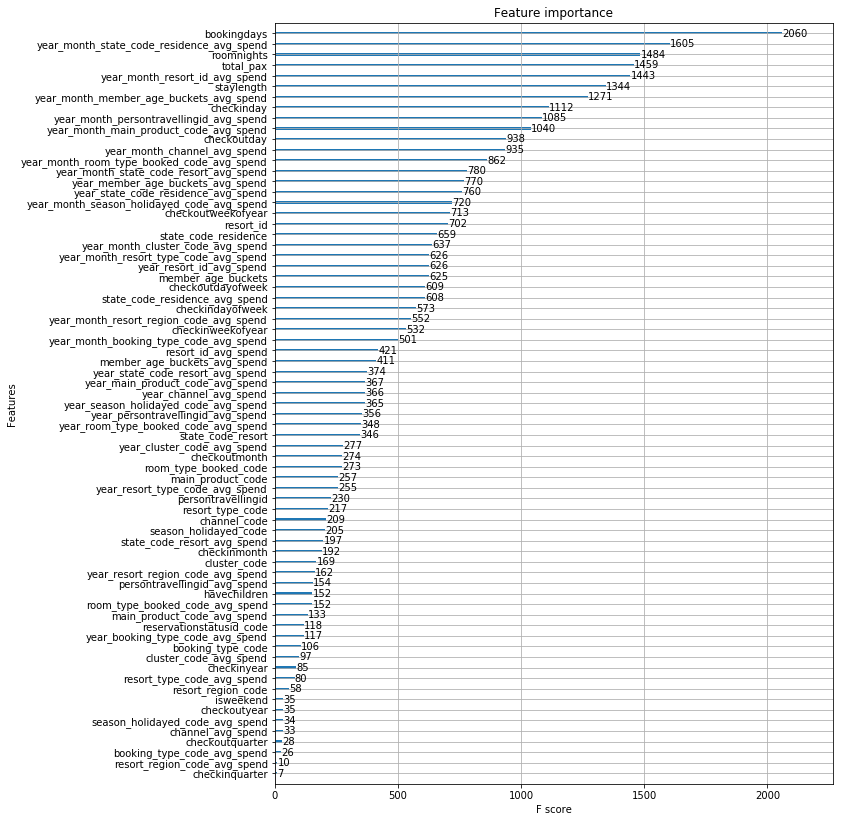

In [18]:
plot_features(model, (10,14))